## Импорт библиотек
Импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Polygon, Point, MultiPolygon
from shapely.ops import cascaded_union
import contextily as cx

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.dummy import DummyRegressor, DummyClassifier

import lightgbm as lgb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.metrics import mean_absolute_error, make_scorer, f1_score

from tensorflow import keras
from tensorflow.keras.optimizers import Adam

Init Plugin
Init Graph Optimizer
Init Kernel


Путь к данным:

In [2]:
DATA_PATH = './datasets/'
CLINIC_RADIUS = 1000 #метров до поликлинники по СП 42.13330.2016

## Загрузим датасеты.

### Location
**01_Location_July.csv** и **01_CLocation_July.csv** - Сгенерированный датасет о численности населения на территории Москвы и с гранулярностью по районам города Москвы и секторами 500х500 метров.

***Характер данных***: Данные об изменении численности населения на территории

***Временное разбиение***: календарный месяц

***Территориальное разбиение***: Москва, разбитая по административным районам и на сектора 500х500м.

***Перечень показателей данных в данных:***
- Количество человек, проживающих на территории района/сектора
- Количество человек, работающих на территории района/сектора
- Количество человек, которые находились на территории района/сектора по будням в дневное время чаще, чем в любых других районах/секторах, в рассматриваемый месяц
- Количество человек, проживающих на территории района/сектора и имеющих разъездную работу

In [3]:
df_loc = pd.read_csv(DATA_PATH + '01_Location_July.csv')
print(df_loc.shape)
df_loc.head(3)

(146, 5)


,zid,customers_cnt_home,customers_cnt_job,customers_cnt_day,customers_cnt_move
0,1,31723,11029,23944,1411
1,2,64780,15890,40845,3536
2,3,69098,39701,63486,4161


In [4]:
df_cloc = pd.read_csv(DATA_PATH + '01_CLocation_July.csv')
print(df_cloc.shape)
df_cloc.head(3)

(10240, 5)


,zid,customers_cnt_home,customers_cnt_job,customers_cnt_day,customers_cnt_move
0,32909,4,0,0,0
1,32910,25,8,26,0
2,33261,2,0,2,0


### Matrix_Home_Work

**04_Matrix_Home_Work_July**; **04_CMatrix_Home_Work_July.csv** - Сгенерированный датасет о динамике перемещения населения дом-работа на территории Москвы (Матрица корреспонденции дом-работа) и с гранулярностью по районам города Москвы и секторами 500х500 метров.

***Характер данных***: Данные Матрица корреспонденции дом-работа

***Временное разбиение***: календарный месяц

***Территориальное разбиение***: Москва, разбитая по административным районам и на сектора 500х500м.

***Перечень показателей данных в данных:***

- Количество человек, место проживания которых в отчетном месяце находится в районе/секторе А, а место работы - в районе/секторе В

In [5]:
df_home_work = pd.read_csv(DATA_PATH + '04_Matrix_Home_Work_July.csv')
df_chome_work = pd.read_csv(DATA_PATH + '04_CMatrix_Home_Work_July.csv')
df_chome_work.head(1)

,home_zid,work_zid,customers_cnt
0,-2,33620,2


## Административное деление районов

Загрузим так же справочник соотношения секторов 500х500м и административного деления районов Москвы

In [6]:
df_sector_rel = pd.read_csv(DATA_PATH + 'relations_between_500x500_and_MSC.csv')
df_sector_rel.head(3)

,cell_zid,area_peresechenia_s_admzone_kv.km,adm_zid,adm_name,okrug_name,sub_ter
0,32909,0.407116,216,Роговское,Троицкий административный округ,Новая Москва
1,32910,1.003458,216,Роговское,Троицкий административный округ,Новая Москва
2,33261,0.233312,216,Роговское,Троицкий административный округ,Новая Москва


In [7]:
df_sector_rel['sub_ter'].value_counts()

Новая Москва     6734
Старая Москва    6498
Name: sub_ter, dtype: int64

Список ZID принадлежащих Новой Москве

In [8]:
new_zid_list = df_sector_rel.query('sub_ter == "Новая Москва"')['cell_zid'].to_list()

## Загрузим геоданные

In [9]:
shp_admzones = gpd.read_file(DATA_PATH + 'admzones2021/admzones2021.shp').to_crs(epsg=32637)
shp_fishnet = gpd.read_file(DATA_PATH + 'fishnet2021/fishnet2021.shp').to_crs(epsg=32637)

Оставим только данные, относящиеся к Москве:

In [10]:
shp_moscow = shp_admzones[(shp_admzones['sub_ter'] == 'Старая Москва') |\
                          (shp_admzones['sub_ter'] == 'Новая Москва')]

shp_mosnet = shp_fishnet.sjoin(
    shp_moscow,
    how="inner",
    predicate='intersects').drop('index_right', axis=1)

Поместим значением `cell_zid` на место индекса, и отбросим все дублирующиеся индексы:

In [11]:
shp_mosnet = shp_mosnet.set_index('cell_zid')[~shp_mosnet.index.duplicated(keep='first')].reset_index()

## Загрузим наборы данных с data.mos.ru

Загрузим наборы данных с `data.mos.ru`, а именно:

1. [Поликлиническая помощь взрослым](https://data.mos.ru/opendata/503/)
1. [Поликлиническая помощь детям](https://data.mos.ru/opendata/505/)
1. [Границы зон охраны объектов культурного наследия](https://data.mos.ru/opendata/613/)
1. [Парковые территории](https://data.mos.ru/opendata/1465)

In [12]:
df_adult = pd.read_json(DATA_PATH + 'mos_ru/503_clinic_adult.json', encoding='windows-1251')
df_child = pd.read_json(DATA_PATH + 'mos_ru/505_clinic_child.json', encoding='windows-1251')

df_zculture = pd.read_json(DATA_PATH + 'mos_ru/613_zones_culture.json', encoding='windows-1251')
df_zpark = pd.read_json(DATA_PATH + 'mos_ru/1465_zones_park.json', encoding='windows-1251')

Функция для выделения координаты из данных:

In [13]:
def coords(row):
    data = row['geoData']
    if data['type'] == 'MultiPoint':
        return Point(data['coordinates'][0][0], data['coordinates'][0][1])
    elif data['type'] == 'MultiPolygon':
        try:
            return MultiPolygon(data['coordinates'][0])
        except:
            return Polygon(data['coordinates'][0][0])
    else:
        return Polygon(data['coordinates'][0])

In [14]:
#df_adult[['longitude', 'latitude']] = df_adult.apply(coords, axis=1, result_type='expand')
df_adult['geometry'] = df_adult.apply(coords, axis=1)
df_child['geometry'] = df_child.apply(coords, axis=1)
df_zculture['geometry'] = df_zculture.apply(coords, axis=1)
df_zpark['geometry'] = df_zpark.apply(coords, axis=1)

Объединим объекты одного типа в общие DataFrame (клиники к клиникам, запретные зоны к запретным зонам)

In [15]:
df_adult['age'] = 'adult'
df_child['age'] = 'child'
df_zculture['zone_type'] = 'culture'
df_zculture['name'] = df_zculture['ObjectNameOnDoc']
df_zpark['zone_type'] = 'park'
df_zpark['name'] = df_zpark['CommonName']

df_clinic = pd.concat((df_adult, df_child))[['ShortName', 'age', 'geometry']]
df_zones = pd.concat((df_zculture, df_zpark))[['name', 'geometry']]

Создадим объекты типа **GeoDataFrame**

In [16]:
gdf_clinic = gpd.GeoDataFrame(
    df_clinic, geometry=df_clinic.geometry,
    crs="EPSG:4326").to_crs(epsg=32637)

gdf_zones = gpd.GeoDataFrame(
    df_zones, geometry=df_zones.geometry,
    crs="EPSG:4326").to_crs(epsg=32637)

Добавим данные о реальном местоположении перспективного строительства объектов здравоохранения, собранные вручную с портала [ИАИС ОГД](https://isogd.mos.ru/), для проверки работоспособности нашей модели.

In [17]:
df_plan = pd.read_csv(DATA_PATH + 'extracted_points.csv')
gdf_plan = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(df_plan['Y'], df_plan['X'], crs="EPSG:4326")).to_crs(epsg=32637)

Добавим буфера - зоны диаметром в зону обслуживания поликлинники в соответствии с *СП 42.13330.2016 "Градостроительство. Планировка и застройка городских и сельских поселений"*

In [18]:
def createBuffer(main_gdf, add_gdf, radius=CLINIC_RADIUS):
    sec_gdf = add_gdf.copy()
    sec_gdf.geometry = gpd.GeoSeries(cascaded_union(sec_gdf.geometry.buffer(radius)))
    served_list = []
    served_list = gpd.overlay(main_gdf, sec_gdf, how='intersection')['cell_zid'].unique()
    return served_list

## Анализ

Приступим к анализу полученных данных, для начала объединим данные по численности населения с картой Москвы:

In [19]:
gdf_cloc = pd.merge(shp_mosnet,
                    df_cloc,
                    how="inner",
                    left_on='cell_zid',
                    right_on='zid',
                    sort=False,
                    suffixes=("_x", "_y"),
                    copy=True,
                    indicator=False,
                    validate=None).drop(columns='zid')

Добавим все сектора, обслуживаемые хоть одной поликлинникой

In [20]:
# Если подобную зону надо отрисовать отдельно:
#gdf_served = gpd.overlay(gdf_cloc, clinic_buff, how='intersection')[['cell_zid', 'geometry']]

served_list_1k = createBuffer(gdf_cloc, gdf_clinic)
plan_list_1k = createBuffer(gdf_cloc, gdf_plan)

In [21]:
#gdf_cloc['served'] = np.where(gdf_cloc['cell_zid'].isin(served_list_1k), 0.25, 0)
#gdf_cloc.loc[gdf_cloc['cell_zid'].isin(served_list_500), 'served'] = 0.5
#gdf_cloc.loc[gdf_cloc['cell_zid'].isin(served_list_250), 'served'] = 1.0
gdf_cloc['served'] = np.where(gdf_cloc['cell_zid'].isin(served_list_1k), 1, 0)

Отобразим часть зон обслуживания на карте:

Также добавим все сектора, в которых строить нежелательно (парки, зоны культурного наследия)

In [22]:
stop_list = gpd.overlay(gdf_cloc, gdf_zones, how='intersection')['cell_zid'].unique()

gdf_cloc['blocked'] = np.where(gdf_cloc['cell_zid'].isin(stop_list), 1, 0)

Добавим новые признаки на основе среднего значения по районам:

In [23]:
mean_cloc = gdf_cloc[['adm_name',
                      'customers_cnt_home',
                      'customers_cnt_job',
                      'customers_cnt_day',
                      'customers_cnt_move']].groupby('adm_name').transform('mean').round()
mean_cloc.columns = ['mean_home', 'mean_job', 'mean_day', 'mean_move']
gdf_cloc = pd.concat([gdf_cloc, mean_cloc], axis=1)

Следовательно, относительные признаки представляют собой:

In [24]:
gdf_cloc['rel_home'] = gdf_cloc['customers_cnt_home'] / gdf_cloc['mean_home']
gdf_cloc['rel_job'] = gdf_cloc['customers_cnt_job'] / gdf_cloc['mean_job'] 
gdf_cloc['rel_day'] = gdf_cloc['customers_cnt_day'] / gdf_cloc['mean_day'] 
gdf_cloc['rel_move'] = gdf_cloc['customers_cnt_move'] / gdf_cloc['mean_move'] 

И как это выглядит на карте:

<AxesSubplot:>

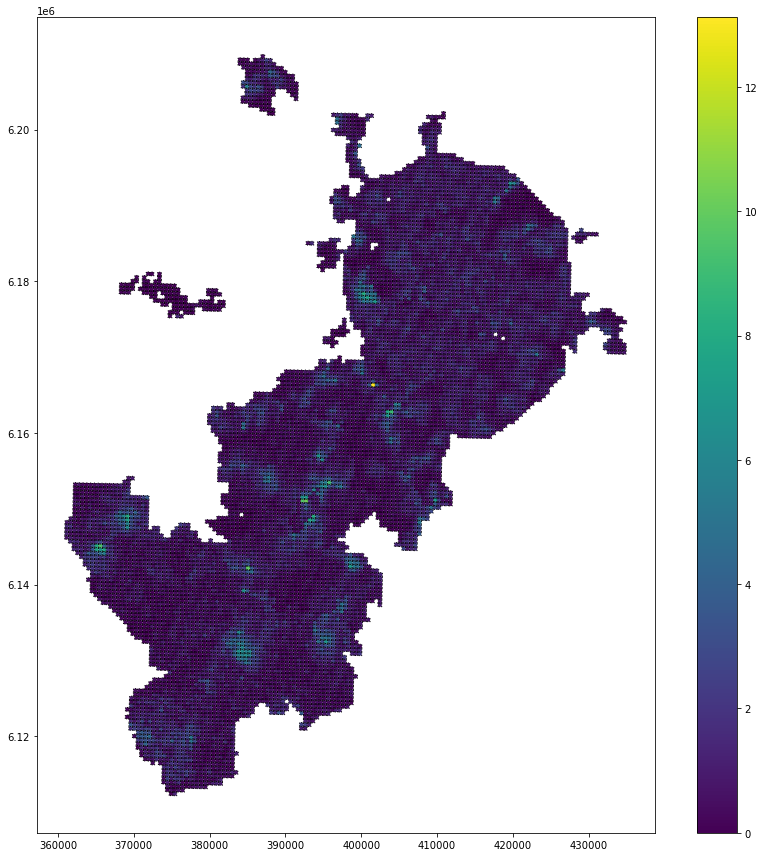

In [25]:
gdf_cloc.plot(figsize=(15,15),
                        linestyle=':',
                        edgecolor='black',
                        column='rel_day',
                        legend=True)

## Подготовка данных для модели

Подготовим наши признаки, не забыв удалить дубликаты:

In [26]:
data = gdf_cloc[['cell_zid',
                 'sub_ter',
                 'rel_home',
                 'rel_job',
                 'rel_day',
                 'rel_move',
                 'served']].drop_duplicates().copy().set_index('cell_zid')
#                 'blocked']].drop_duplicates().copy().set_index('cell_zid')

data['sub_ter'] = np.where(data['sub_ter']=='Старая Москва', 0, 1)
data = data[~data.index.duplicated(keep='first')]

In [27]:
data.tail(10)

,sub_ter,rel_home,rel_job,rel_day,rel_move,served
cell_zid,,,,,,
138915,0,0.764323,4.126154,2.567233,0.542857,0
139343,0,0.097656,0.716923,0.415765,0.142857,0
138061,0,2.139390,1.139483,1.543580,2.250000,1
138062,0,1.409154,0.562430,0.876248,1.307692,1
138063,0,0.490985,0.235096,0.343313,0.403846,1
138487,0,0.079750,0.566929,0.376580,0.076923,0
138488,0,0.833564,2.046119,1.561544,0.692308,1
138489,0,1.316921,1.229471,1.269461,1.480769,1
138490,0,0.892510,0.343082,0.582169,0.923077,1


Разделим на тренировочную и тестовые выборки по территориальному признаку (Старая Москва/Новая Москва):

In [28]:
train = data.loc[data['sub_ter'] == 0].drop('sub_ter', axis=1).copy()
test = data.loc[data['sub_ter'] == 1].drop('sub_ter', axis=1).reset_index().copy()

In [29]:
test['served'] = np.where(test['cell_zid'].isin(plan_list_1k), 1, 0)

In [30]:
X_train = train.copy()
X_test = test.set_index('cell_zid').copy()

y_train = X_train.pop('served')
y_test = X_test.pop('served')

## Моделирование:

### Baseline
для проверки на адекватность (`DummyClassifier()`):

In [31]:
%%time
model = DummyClassifier(strategy='uniform', random_state=13)

model.fit(X_train, y_train)

preds = pd.Series(model.predict(X_test), index=X_test.index, name='predicted')

print('F1_score (DummyClassifier)', f1_score(y_test, preds), end='\n\n')

F1_score (DummyClassifier) 0.5675187969924811

CPU times: user 5.83 ms, sys: 3.06 ms, total: 8.88 ms
Wall time: 3.25 ms


### Разные модели:

Случайный лес

In [32]:
%%time
model = RandomForestClassifier(n_estimators=100,
                               max_depth=8,
                               n_jobs=-1,
                               random_state=13)

model.fit(X_train, y_train)

preds = pd.Series(model.predict(X_test), index=X_test.index, name='predicted')
preds_proba = pd.Series(model.predict_proba(X_test)[:,1].round(3), index=X_test.index, name='predicted')

print('F1_score (RandomForestClassifier)', f1_score(y_test, preds), end='\n\n')

F1_score (RandomForestClassifier) 0.6670612607280262

CPU times: user 534 ms, sys: 96 ms, total: 630 ms
Wall time: 185 ms


Логистическая регрессия

In [33]:
%%time
model = LogisticRegression(n_jobs=-1)

model.fit(X_train, y_train)

preds = pd.Series(model.predict(X_test), index=X_test.index, name='predicted')
preds_proba = pd.Series(model.predict_proba(X_test)[:,1].round(3), index=X_test.index, name='predicted')

print('F1_score (LogisticRegression)', f1_score(y_test, preds), end='\n\n')

F1_score (LogisticRegression) 0.7504536107415023

CPU times: user 25.9 ms, sys: 77.4 ms, total: 103 ms
Wall time: 479 ms


Также протестируем TensorFlow

In [34]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(units=16, input_dim=X_train.shape[1]))
model.add(keras.layers.Dense(units=8, activation='relu'))
model.add(keras.layers.Dense(units=1, activation='sigmoid'))

model.compile(loss='mean_squared_error',
              optimizer=Adam(learning_rate=0.05),
              metrics=['MAE'])

#model.fit(X_train, y_train, epochs=15, verbose=0, validation_split = 0.2)

Metal device set to: Apple M1


2021-11-06 00:04:41.112754: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-06 00:04:41.112871: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [35]:
#preds = model.predict(X_test)
#print('F1_score (KERAS)', f1_score(y_test, preds>=0.5))
print('F1_score (KERAS)', 0.7449)

F1_score (KERAS) 0.7449


### Градиентный спуск:

In [36]:
%%time
model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    max_depth=-1,
    learning_rate=0.005,
    n_estimators=100,
    random_state=13,
    n_jobs=-1)

model.fit(X_train, y_train)

preds = pd.Series(model.predict(X_test),
                  index=X_test.index, name='predicted') #Предсказание классов

preds_proba = pd.Series(model.predict_proba(X_test)[:,1].round(3),
                        index=X_test.index, name='predicted')

preds_proba = ((preds_proba - preds_proba.min()) / (preds_proba.max() - preds_proba.min())) #Вероятность положительного класса

print('F1_score (LGBMClassifier)', f1_score(y_test, preds), end='\n\n')

F1_score (LGBMClassifier) 0.7828320667879697

CPU times: user 915 ms, sys: 614 ms, total: 1.53 s
Wall time: 352 ms


## Экспорт результата:

Скопируем данные:

In [37]:
final_result = gdf_cloc[['cell_zid', 'geometry', 'adm_zid',
          'adm_name', 'okrug_name', 'sub_ter',
          'okrug_id', 'area', 'customers_cnt_home',
          'customers_cnt_job','customers_cnt_day', 'customers_cnt_move',
          'served', 'blocked']].copy()

И добавим полученные предсказания:

In [38]:
final_result = pd.merge(
    final_result,
    preds_proba,
    how="left",
    on='cell_zid').fillna(0)

Фильтрация:
- Все значения предсказаний, попадающие в заблокированную зону (`blocked = 1`) обнуляются.
- Все значения предсказаний, попадающие в уже обсуженную зону - обнуляются.

In [39]:
final_result['predicted'] = np.where(~(final_result['served'] == 1), final_result['predicted'], 0)

final_result['predicted'] = np.where(~(final_result['blocked'] == 1), final_result['predicted'], 0)

Просмотр результата на карте:

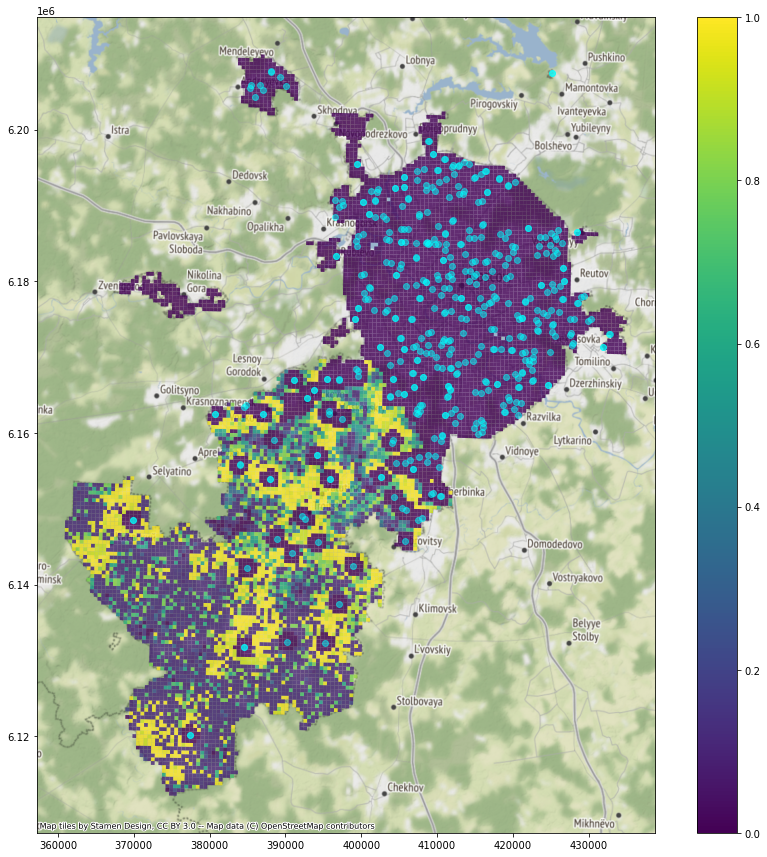

In [40]:
ax = gdf_cloc.plot(figsize=(15,15),
                   linestyle=':',
                   color='blue',
                   edgecolor='whitesmoke',
                   alpha=0.05)

final_result.plot(ax=ax, column='predicted', legend=True, alpha=0.8)
gdf_clinic.plot(ax=ax, color='cyan', alpha=0.5) #Синим - фактические клиники

cx.add_basemap(ax, crs=gdf_cloc.crs)

Наконец - экспорт:

In [42]:
export = final_result.to_crs(epsg=4326)
export.to_csv('export.csv', sep='|')